In [2]:
import yaml
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [105]:
MAP_NAME = "levine_closed"
map_img_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
map_yaml_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"

map_config = yaml.safe_load(open(map_yaml_file, 'r'))
map_resolution, map_origin = map_config['resolution'], map_config['origin']
map_img = np.array(Image.open(map_img_file).transpose(Image.FLIP_TOP_BOTTOM))

racetrack = "/sim_ws/src/f1tenth_gym_ros/tracks/levine_closed.csv"
optim_racedata = pd.read_csv(racetrack, header=0, names=["x", "y", "vel"])
x_optim, y_optim = optim_racedata["x"].values, optim_racedata["y"].values

x_optim, y_optim = (x_optim - map_origin[0]) /  map_resolution, (y_optim - map_origin[1]) /  map_resolution
optim_path = np.vstack((x_optim, y_optim)).T
tree = cKDTree(optim_path)

def function(idx, is_pp = True, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_ppo.csv"):
    race_data = pd.read_csv(file)

    pos_x, pos_y, lin_vel_x = race_data['pos_x'].values[::5], race_data['pos_y'].values[::5], race_data['lin_vel_x'].values[::5]
    time = race_data['time'].values[::5] / 1e9 if not is_pp else race_data['time'].values[::5]
    pos_x, pos_y = (pos_x - map_origin[0]) / map_resolution, (pos_y - map_origin[1]) / map_resolution

    start_x, start_y = pos_x[0], pos_y[0]

    lap_list = np.arange(idx, len(pos_x), len(pos_x)//5)
    min_ids = []
    for k in range(len(lap_list)-1):
        min_dist = np.inf
        for i in range(lap_list[k], lap_list[k+1]):
            dist = np.hypot(pos_x[i]-start_x, pos_y[i]-start_y)
            if dist < min_dist:
                min_dist = dist
                min_idx = i
        min_ids.append(min_idx)
    lap_times = np.array([time[min_ids[i]]-time[lap_list[i]] for i in range(4)])
    if not is_pp:
        lap_time_mean, lap_time_std = lap_times.mean(), lap_times.std()
    else:
        lap_time_mean, lap_time_std = lap_times[1:].mean(), lap_times[1:].std()
        
    tracked_path = np.vstack((pos_x[10:], pos_y[10:])).T
    dists, _ = tree.query(tracked_path)
    mean_error = np.mean(dists)

    return pos_x, pos_y, lin_vel_x, lap_time_mean, lap_time_std, mean_error

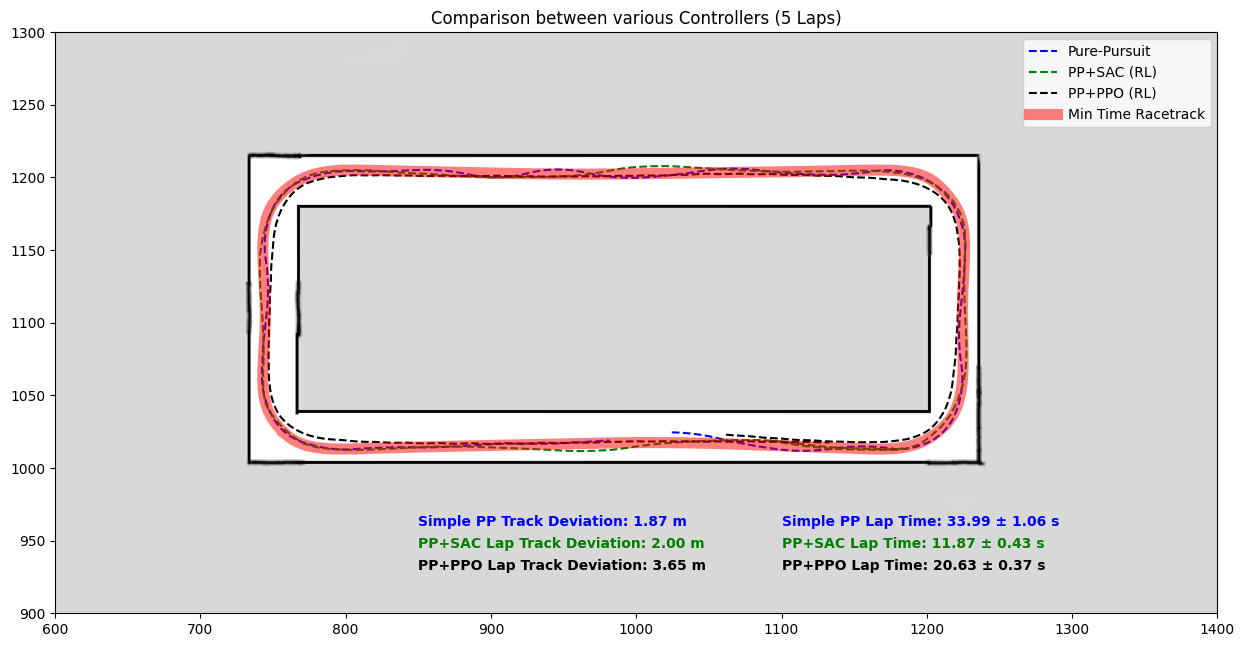

In [92]:
pos_x_pp, pos_y_pp, lin_vel_x_pp, lap_time_pp_mean, lap_time_pp_std, mean_error_pp = function(idx=7, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_levine_closed_pp.csv")
pos_x_sac, pos_y_sac, lin_vel_x_sac, lap_time_sac_mean, lap_time_sac_std, mean_error_sac = function(idx=5, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_closed_sac.csv")
pos_x_ppo, pos_y_ppo, lin_vel_x_ppo, lap_time_ppo_mean, lap_time_ppo_std, mean_error_ppo = function(idx=5, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_closed_ppo.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ax.imshow(map_img, cmap='gray')
ax.plot(pos_x_pp[10:len(pos_x_pp)//5+20], pos_y_pp[10:len(pos_x_pp)//5+20], 'b--', label="Pure-Pursuit")
ax.plot(pos_x_sac[10:len(pos_x_sac)//5+20], pos_y_sac[10:len(pos_x_sac)//5+20], 'g--', label="PP+SAC (RL)")
ax.plot(pos_x_ppo[10:len(pos_x_ppo)//5+20], pos_y_ppo[10:len(pos_y_ppo)//5+20], 'k--', label="PP+PPO (RL)")
ax.plot(x_optim, y_optim, 'r', label="Min Time Racetrack", alpha=0.5, linewidth=8)

ax.set_xlim(600, 1400)
ax.set_ylim(900, 1300)
ax.set_title("Comparison between various Controllers (5 Laps)")

ax.text(
    x=850, y=960, 
    s=f"Simple PP Track Deviation: {mean_error_pp:.2f} m", 
    fontweight='heavy', color='blue'
)
ax.text(
    x=850, y=945, 
    s=f"PP+SAC Lap Track Deviation: {mean_error_sac:.2f} m", 
    fontweight='heavy', color='green'
)
ax.text(
    x=850, y=930, 
    s=f"PP+PPO Lap Track Deviation: {mean_error_ppo:.2f} m", 
    fontweight='heavy', color='black'
)

ax.text(
    x=1100, y=960, 
    s=f"Simple PP Lap Time: {lap_time_pp_mean:.2f} ± {lap_time_pp_std:.2f} s", 
    fontweight='heavy', color='blue'
)
ax.text(
    x=1100, y=945, 
    s=f"PP+SAC Lap Time: {lap_time_sac_mean:.2f} ± {lap_time_sac_std:.2f} s", 
    fontweight='heavy', color='green'
)
ax.text(
    x=1100, y=930, 
    s=f"PP+PPO Lap Time: {lap_time_ppo_mean:.2f} ± {lap_time_ppo_std:.2f} s", 
    fontweight='heavy', color='black'
)
ax.legend(loc='upper right')

plt.show()

In [34]:
racetrack = "/sim_ws/src/f1tenth_gym_ros/tracks/levine_closed.csv"
file = "/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_pp.csv"
file2 = "/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_sac.csv"

MAP_NAME = "levine_closed"
map_img_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
map_yaml_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"

map_config = yaml.safe_load(open(map_yaml_file, 'r'))
map_resolution = map_config['resolution']
map_origin = map_config['origin']

map_img = np.array(Image.open(map_img_file).transpose(Image.FLIP_TOP_BOTTOM))
map_height, map_width = map_img.shape

race_data = pd.read_csv(file)
race_data_2 = pd.read_csv(file2)

pos_x, pos_y, lin_vel_x = race_data['pos_x'].values[::30], race_data['pos_y'].values[::30], race_data['lin_vel_x'].values[::30]
time = race_data['time'].values[::30]
pos_x_2, pos_y_2, lin_vel_x_2 = race_data_2['pos_x'].values[::5], race_data_2['pos_y'].values[::5], race_data_2['lin_vel_x'].values[::5]
time_2 = race_data_2['time'].values[::5]

optim_racedata = pd.read_csv(racetrack, header=0, names=["x", "y", "vel"])
x_optim, y_optim = optim_racedata["x"].values, optim_racedata["y"].values

In [35]:
pos_x -= map_origin[0]
pos_y -= map_origin[1]
pos_x_2 -= map_origin[0]
pos_y_2 -= map_origin[1]

pos_x /= map_resolution
pos_y /= map_resolution
pos_x_2 /= map_resolution
pos_y_2 /= map_resolution

x_optim -= map_origin[0]
y_optim -= map_origin[0]

x_optim /= map_resolution
y_optim /= map_resolution

In [39]:
start_x, start_y = pos_x[0], pos_y[0]

min_dist = np.inf
for i in range(2, len(pos_x)):
    dist = np.hypot(pos_x[i]-start_x, pos_y[i]-start_y)
    if dist < min_dist:
        min_dist = dist
        min_idx = i

lap_time = round(time[min_idx] - time[0], 3)

start_x_2, start_y_2 = pos_x_2[0], pos_y_2[0]

min_dist = np.inf
for i in range(6, len(pos_x_2)):
    dist = np.hypot(pos_x_2[i]-start_x_2, pos_y_2[i]-start_y_2)
    if dist < min_dist:
        min_dist = dist
        min_idx = i

lap_time_2 = round(time[min_idx] - time[0], 3)


In [40]:
optim_path = np.vstack((x_optim, y_optim)).T
tracked_path = np.vstack((pos_x, pos_y)).T
tracked_path_2 = np.vstack((pos_x_2, pos_y_2)).T

tree = cKDTree(optim_path)
dists, _ = tree.query(tracked_path)
dists2, _ = tree.query(tracked_path_2)

mean_error = np.mean(dists)
mean_error_2 = np.mean(dists2)


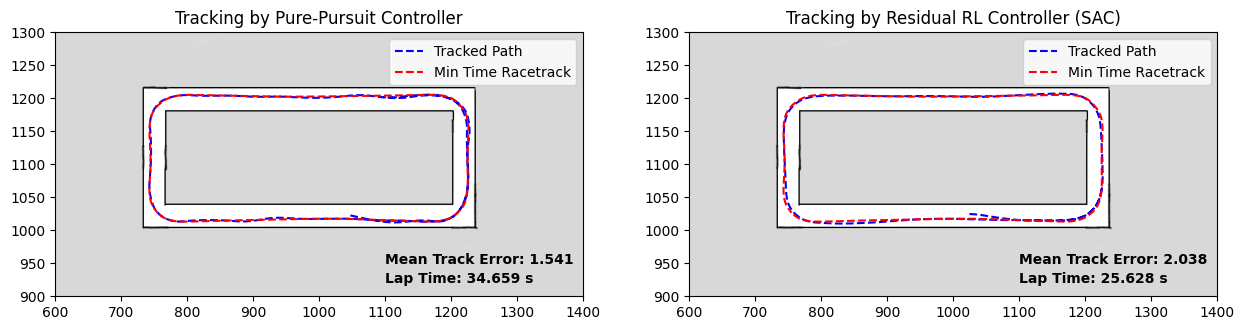

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

ax[0].imshow(map_img, cmap='gray')
ax[0].plot(pos_x, pos_y, 'b--', label="Tracked Path")
ax[0].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)
ax[0].set_title("Tracking by Pure-Pursuit Controller")
ax[0].text(x=1100, y=950, s=f"Mean Track Error: {mean_error:.3f}", fontweight='heavy')
ax[0].text(x=1100, y=920, s=f"Lap Time: {lap_time} s", fontweight='heavy')
ax[0].legend(loc='upper right')

ax[1].imshow(map_img, cmap='gray')
ax[1].plot(pos_x_2, pos_y_2, 'b--', label="Tracked Path")
ax[1].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)
ax[1].set_title("Tracking by Residual RL Controller (SAC)")
ax[1].text(x=1100, y=950, s=f"Mean Track Error: {mean_error_2:.3f}", fontweight='heavy')
ax[1].text(x=1100, y=920, s=f"Lap Time: {lap_time_2} s", fontweight='heavy')
ax[1].legend(loc='upper right')

plt.show()

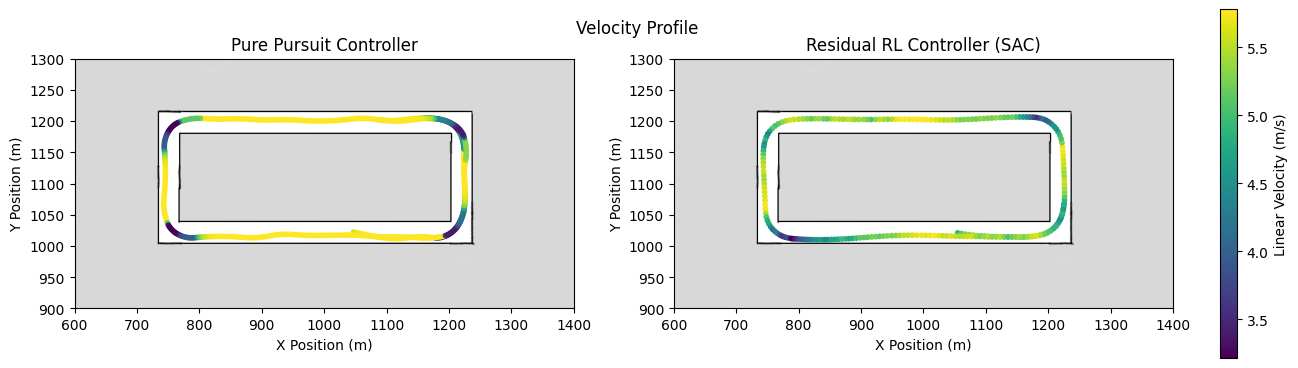

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sc = ax[0].scatter(pos_x, pos_y, c=lin_vel_x, cmap='viridis', s=10)
ax[0].imshow(map_img, cmap='gray')
ax[0].set_xlabel("X Position (m)")
ax[0].set_ylabel("Y Position (m)")
ax[0].set_title("Pure Pursuit Controller")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)

sc2 = ax[1].scatter(pos_x_2[10:], pos_y_2[10:], c=lin_vel_x_2[10:], cmap='viridis', s=10)
ax[1].imshow(map_img, cmap='gray')
ax[1].set_xlabel("X Position (m)")
ax[1].set_ylabel("Y Position (m)")
ax[1].set_title("Residual RL Controller (SAC)")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)

cbar = fig.colorbar(sc2, ax=ax, orientation='vertical', fraction=0.015, pad=0.04)
cbar.set_label("Linear Velocity (m/s)")
plt.suptitle("Velocity Profile", y=0.7)
plt.show()

In [48]:
file3 = "/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_ppo.csv"

race_data_3 = pd.read_csv(file3)

pos_x_3, pos_y_3, lin_vel_x_3 = race_data_3['pos_x'].values[::5], race_data_3['pos_y'].values[::5], race_data_3['lin_vel_x'].values[::5]
time_3 = race_data_3['time'].values[::5]


pos_x_3 -= map_origin[0]
pos_y_3 -= map_origin[1]

pos_x_3 /= map_resolution
pos_y_3 /= map_resolution

start_x_3, start_y_3 = pos_x_3[0], pos_y_3[0]

min_dist = np.inf
for i in range(6, len(pos_x_3)):
    dist = np.hypot(pos_x_3[i]-start_x_3, pos_y_3[i]-start_y_3)
    if dist < min_dist:
        min_dist = dist
        min_idx = i

lap_time_3 = round(time[min_idx] - time[0], 3)

tracked_path_3 = np.vstack((pos_x_3, pos_y_3)).T
dists3, _ = tree.query(tracked_path_3)
mean_error_3 = np.mean(dists3)

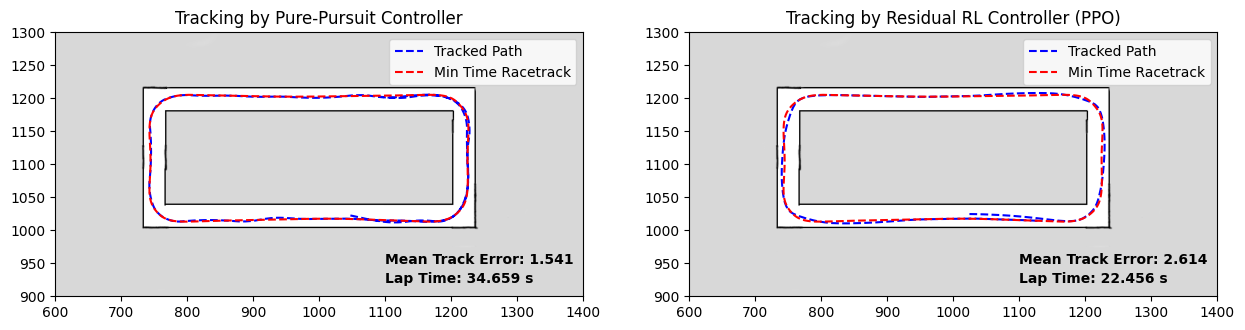

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

ax[0].imshow(map_img, cmap='gray')
ax[0].plot(pos_x, pos_y, 'b--', label="Tracked Path")
ax[0].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)
ax[0].set_title("Tracking by Pure-Pursuit Controller")
ax[0].text(x=1100, y=950, s=f"Mean Track Error: {mean_error:.3f}", fontweight='heavy')
ax[0].text(x=1100, y=920, s=f"Lap Time: {lap_time} s", fontweight='heavy')
ax[0].legend(loc='upper right')

ax[1].imshow(map_img, cmap='gray')
ax[1].plot(pos_x_3, pos_y_3, 'b--', label="Tracked Path")
ax[1].plot(x_optim, y_optim, 'r--', label="Min Time Racetrack")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)
ax[1].set_title("Tracking by Residual RL Controller (PPO)")
ax[1].text(x=1100, y=950, s=f"Mean Track Error: {mean_error_3:.3f}", fontweight='heavy')
ax[1].text(x=1100, y=920, s=f"Lap Time: {lap_time_3} s", fontweight='heavy')
ax[1].legend(loc='upper right')

plt.show()

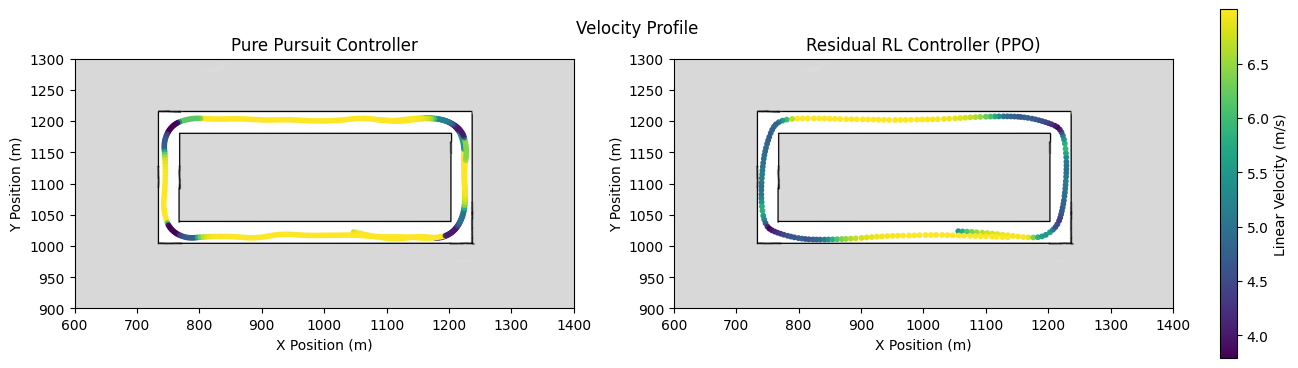

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

sc = ax[0].scatter(pos_x, pos_y, c=lin_vel_x, cmap='viridis', s=10)
ax[0].imshow(map_img, cmap='gray')
ax[0].set_xlabel("X Position (m)")
ax[0].set_ylabel("Y Position (m)")
ax[0].set_title("Pure Pursuit Controller")
ax[0].set_xlim(600, 1400)
ax[0].set_ylim(900, 1300)

sc2 = ax[1].scatter(pos_x_3[10:], pos_y_3[10:], c=lin_vel_x_3[10:], cmap='viridis', s=10)
ax[1].imshow(map_img, cmap='gray')
ax[1].set_xlabel("X Position (m)")
ax[1].set_ylabel("Y Position (m)")
ax[1].set_title("Residual RL Controller (PPO)")
ax[1].set_xlim(600, 1400)
ax[1].set_ylim(900, 1300)

cbar = fig.colorbar(sc2, ax=ax, orientation='vertical', fraction=0.015, pad=0.04)
cbar.set_label("Linear Velocity (m/s)")
plt.suptitle("Velocity Profile", y=0.7)
plt.show()

In [74]:
def give_map(map_name="Spielberg", is_center=False):
    MAP_NAME = map_name
    if is_center:
        TRACK_NAME = MAP_NAME + "_centerline"
    else:
        TRACK_NAME = MAP_NAME
    map_img_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.png"
    map_yaml_file = f"/sim_ws/src/f1tenth_gym_ros/maps/{MAP_NAME}.yaml"

    map_config = yaml.safe_load(open(map_yaml_file, 'r'))
    map_resolution, map_origin = map_config['resolution'], map_config['origin']
    map_img = np.array(Image.open(map_img_file).transpose(Image.FLIP_TOP_BOTTOM))

    racetrack = f"/sim_ws/src/f1tenth_gym_ros/tracks/{TRACK_NAME}.csv"
    centerline_racedata = pd.read_csv(racetrack, header=0, names=["x", "y", "g1", "g2"])
    x_centerline, y_centerline = centerline_racedata["x"].values, centerline_racedata["y"].values

    x_centerline, y_centerline = (x_centerline - map_origin[0]) /  map_resolution, (y_centerline - map_origin[1]) /  map_resolution
    centerline_path = np.vstack((x_centerline, y_centerline)).T
    tree = cKDTree(centerline_path)
    return x_centerline, y_centerline, tree, map_img, map_origin, map_resolution

def function_diff(idx, tree, map_origin, map_resolution, is_pp = True, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_ppo.csv"):
    race_data = pd.read_csv(file)

    pos_x, pos_y, lin_vel_x = race_data['pos_x'].values[::5], race_data['pos_y'].values[::5], race_data['lin_vel_x'].values[::5]
    time = race_data['time'].values[::5] / 1e9 if not is_pp else race_data['time'].values[::5]
    pos_x, pos_y = (pos_x - map_origin[0]) / map_resolution, (pos_y - map_origin[1]) / map_resolution

    start_x, start_y = pos_x[0], pos_y[0]

    min_dist = np.inf
    for i in range(idx , len(pos_x)):
        dist = np.hypot(pos_x[i]-start_x, pos_y[i]-start_y)
        if dist < min_dist:
            min_dist = dist
            min_idx = i
    lap_time = round(time[min_idx]-time[0], 3)
        
    tracked_path = np.vstack((pos_x[10:], pos_y[10:])).T
    dists, _ = tree.query(tracked_path)
    mean_error = np.mean(dists)

    return pos_x, pos_y, lin_vel_x, lap_time, mean_error

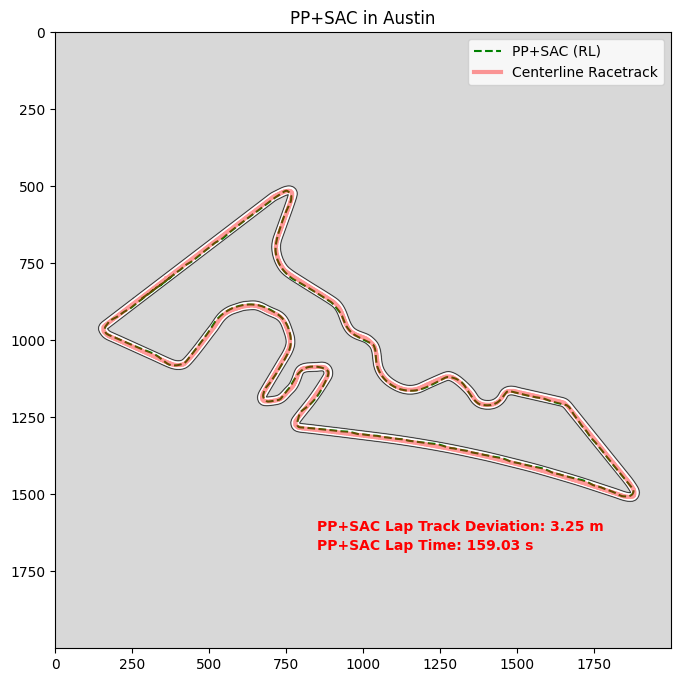

In [75]:
x_centerline_sp, y_centerline_sp, tree_sp, map_img_sp, map_origin, map_resolution = give_map(map_name="Austin")
pos_x_sac, pos_y_sac, lin_vel_x_sac, lap_time_sac_mean, mean_error_sac = function_diff(idx=10, tree=tree_sp, map_origin=map_origin, map_resolution=map_resolution, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_Austin_sac.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ax.imshow(map_img_sp, cmap='gray')
ax.plot(pos_x_sac[10:], pos_y_sac[10:], 'g--', label="PP+SAC (RL)")
ax.plot(x_centerline_sp, y_centerline_sp, 'r', label="Centerline Racetrack", alpha=0.4, linewidth=3)

ax.set_title("PP+SAC in Austin")

ax.text(
    x=850, y=1620, 
    s=f"PP+SAC Lap Track Deviation: {mean_error_sac:.2f} m", 
    fontweight='heavy', color='red'
)

ax.text(
    x=850, y=1680, 
    s=f"PP+SAC Lap Time: {lap_time_sac_mean:.2f} s", 
    fontweight='heavy', color='red'
)

ax.legend(loc='upper right')

plt.show()

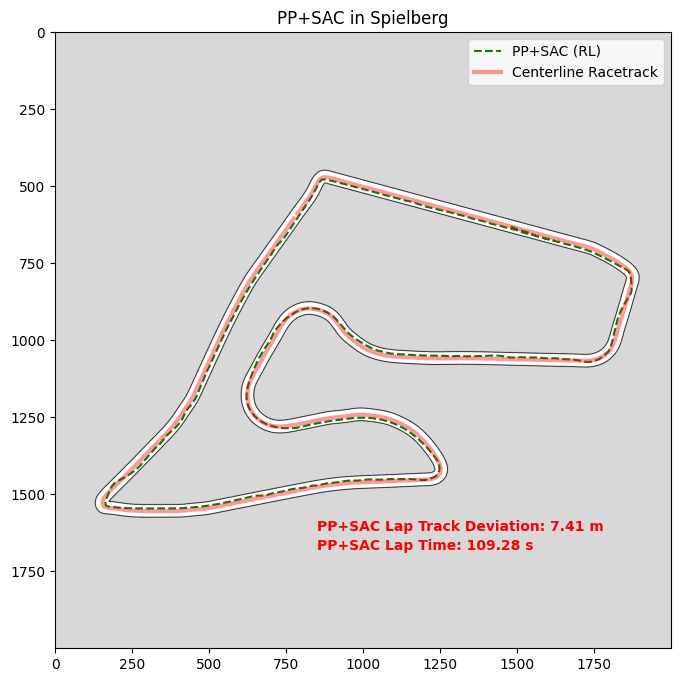

In [76]:
x_centerline_sp, y_centerline_sp, tree_sp, map_img_sp, map_origin, map_resolution = give_map(map_name="Spielberg")
pos_x_sac, pos_y_sac, lin_vel_x_sac, lap_time_sac_mean, mean_error_sac = function_diff(idx=10, tree=tree_sp, map_origin=map_origin, map_resolution=map_resolution, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_Spielberg_sac.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

ax.imshow(map_img_sp, cmap='gray')
ax.plot(pos_x_sac[10:], pos_y_sac[10:], 'g--', label="PP+SAC (RL)")
ax.plot(x_centerline_sp, y_centerline_sp, 'r', label="Centerline Racetrack", alpha=0.4, linewidth=3)

ax.set_title("PP+SAC in Spielberg")

ax.text(
    x=850, y=1620, 
    s=f"PP+SAC Lap Track Deviation: {mean_error_sac:.2f} m", 
    fontweight='heavy', color='red'
)

ax.text(
    x=850, y=1680, 
    s=f"PP+SAC Lap Time: {lap_time_sac_mean:.2f} s", 
    fontweight='heavy', color='red'
)

ax.legend(loc='upper right')

plt.show()

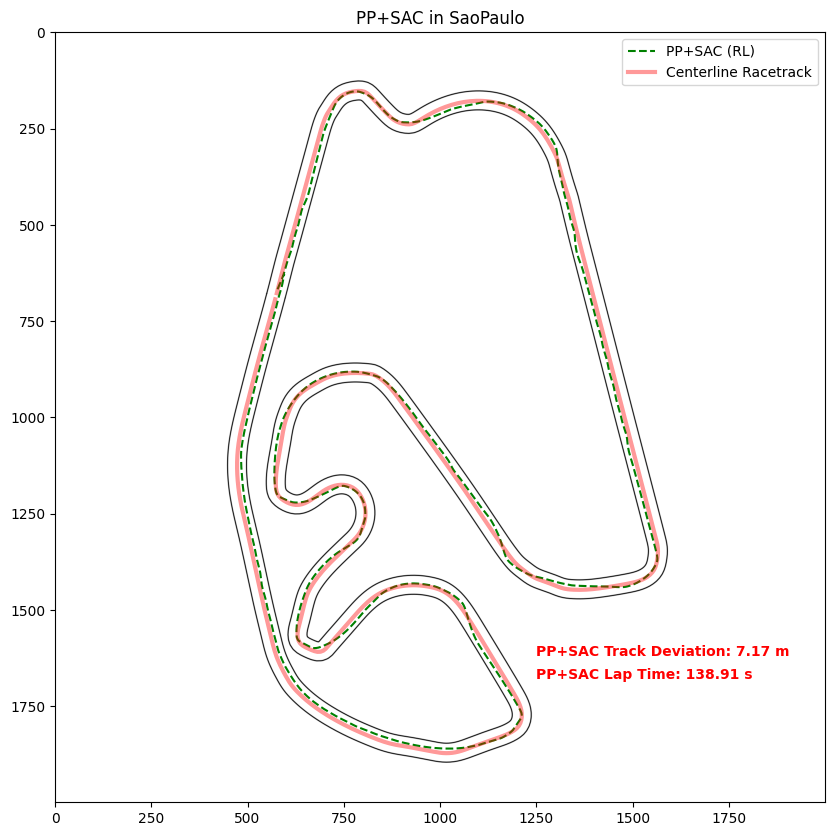

In [77]:
x_centerline_sp, y_centerline_sp, tree_sp, map_img_sp, map_origin, map_resolution = give_map(map_name="SaoPaulo")
pos_x_sac, pos_y_sac, lin_vel_x_sac, lap_time_sac_mean, mean_error_sac = function_diff(idx=10, tree=tree_sp, map_origin=map_origin, map_resolution=map_resolution, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_SaoPaulo_sac.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

ax.imshow(map_img_sp, cmap='gray')
ax.plot(pos_x_sac[10:], pos_y_sac[10:], 'g--', label="PP+SAC (RL)")
ax.plot(x_centerline_sp, y_centerline_sp, 'r', label="Centerline Racetrack", alpha=0.4, linewidth=3)

ax.set_title("PP+SAC in SaoPaulo")

ax.text(
    x=1250, y=1620, 
    s=f"PP+SAC Track Deviation: {mean_error_sac:.2f} m", 
    fontweight='heavy', color='red'
)

ax.text(
    x=1250, y=1680, 
    s=f"PP+SAC Lap Time: {lap_time_sac_mean:.2f} s", 
    fontweight='heavy', color='red'
)

ax.legend(loc='upper right')

plt.show()

In [93]:
x_centerline_sp, y_centerline_sp, tree_sp, map_img_sp, map_origin, map_resolution = give_map(map_name="levine_closed", is_center=True)
pos_x_sac, pos_y_sac, lin_vel_x_sac, lap_time_sac_mean, mean_error_sac = function(idx=10, tree=tree_sp, map_origin=map_origin, map_resolution=map_resolution, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_closed_centerline_sac.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.imshow(map_img_sp, cmap='gray')
ax.plot(pos_x_sac[10:], pos_y_sac[10:], 'g--', label="PP+SAC (RL)")
ax.plot(x_centerline_sp, y_centerline_sp, 'r', label="Centerline Racetrack", alpha=0.4, linewidth=3)
ax.set_xlim(600, 1400)
ax.set_ylim(900, 1300)
ax.set_title("PP+SAC in SaoPaulo")

ax.text(
    x=1100, y=920, 
    s=f"PP+SAC Track Deviation: {mean_error_sac:.2f} m", 
    fontweight='heavy', color='red'
)

ax.text(
    x=1100, y=950, 
    s=f"PP+SAC Lap Time: {lap_time_sac_mean:.2f} s", 
    fontweight='heavy', color='red'
)

ax.legend(loc='upper right')

plt.show()

TypeError: function() got an unexpected keyword argument 'tree'

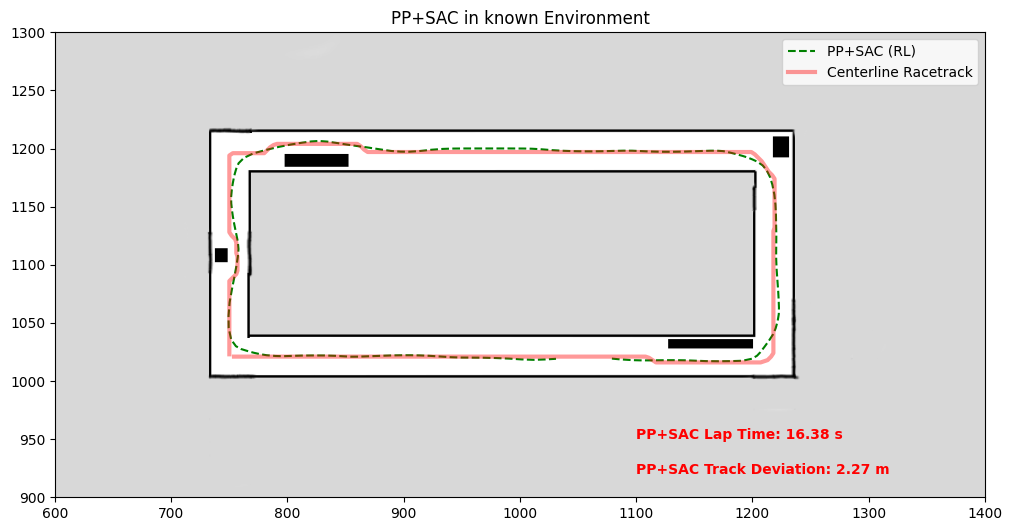

In [99]:
x_centerline_sp, y_centerline_sp, tree_sp, map_img_sp, map_origin, map_resolution = give_map(map_name="levine_closed_static_obstacle", is_center=False)
pos_x_sac, pos_y_sac, lin_vel_x_sac, lap_time_sac_mean, mean_error_sac = function_diff(idx=10, tree=tree_sp, map_origin=map_origin, map_resolution=map_resolution, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_closed_sac_obstacle.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.imshow(map_img_sp, cmap='gray')
ax.plot(pos_x_sac[10:len(pos_x_sac)], pos_y_sac[10:], 'g--', label="PP+SAC (RL)")
ax.plot(x_centerline_sp, y_centerline_sp, 'r', label="Centerline Racetrack", alpha=0.4, linewidth=3)
ax.set_xlim(600, 1400)
ax.set_ylim(900, 1300)
ax.set_title("PP+SAC in known Environment")

ax.text(
    x=1100, y=920, 
    s=f"PP+SAC Track Deviation: {mean_error_sac:.2f} m", 
    fontweight='heavy', color='red'
)

ax.text(
    x=1100, y=950, 
    s=f"PP+SAC Lap Time: {lap_time_sac_mean:.2f} s", 
    fontweight='heavy', color='red'
)

ax.legend(loc='upper right')

plt.show()

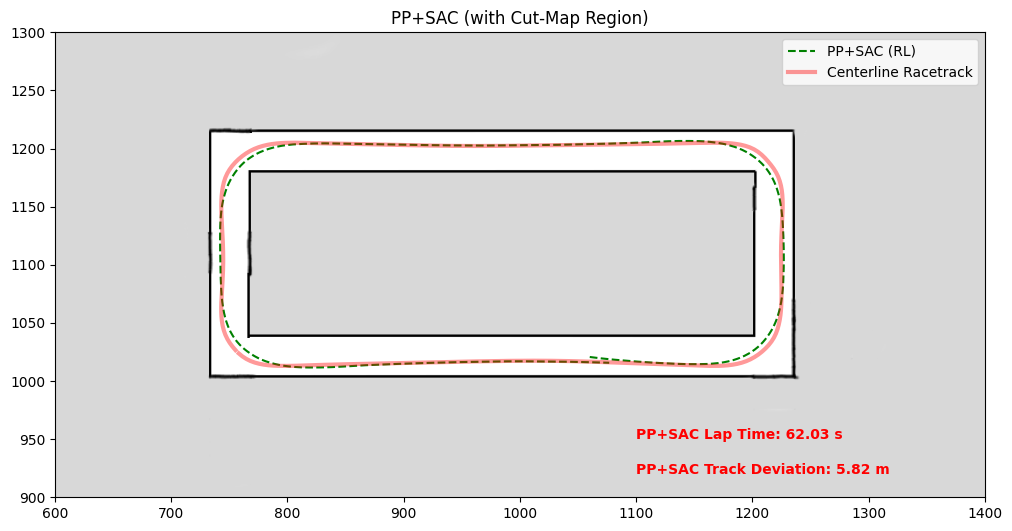

In [111]:
x_centerline_sp, y_centerline_sp, tree_sp, map_img_sp, map_origin, map_resolution = give_map(map_name="levine_closed", is_center=True)
pos_x_sac, pos_y_sac, lin_vel_x_sac, lap_time_sac_mean, mean_error_sac = function_diff(idx=10, tree=tree_sp, map_origin=map_origin, map_resolution=map_resolution, is_pp=False, file="/sim_ws/src/f1tenth_gym_ros/race_logs/race_log_rl_levine_closed_sac_mapimg.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.imshow(map_img_sp, cmap='gray')
ax.plot(pos_x_sac[20:], pos_y_sac[20:], 'g--', label="PP+SAC (RL)")
ax.plot(x_optim, y_optim, 'r', label="Centerline Racetrack", alpha=0.4, linewidth=3)
ax.set_xlim(600, 1400)
ax.set_ylim(900, 1300)
ax.set_title("PP+SAC (with Cut-Map Region)")

ax.text(
    x=1100, y=920, 
    s=f"PP+SAC Track Deviation: {mean_error_sac:.2f} m", 
    fontweight='heavy', color='red'
)

ax.text(
    x=1100, y=950, 
    s=f"PP+SAC Lap Time: {lap_time_sac_mean:.2f} s", 
    fontweight='heavy', color='red'
)

ax.legend(loc='upper right')

plt.show()